## import

In [13]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import DaNet
from tqdm import tqdm

# setting

In [14]:
artifacts_path = Path("../../artifacts/dual-attention")
data_path = Path("../../data")

In [15]:
DEVICE = torch.device("cuda:0")

# data

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [17]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)


In [18]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


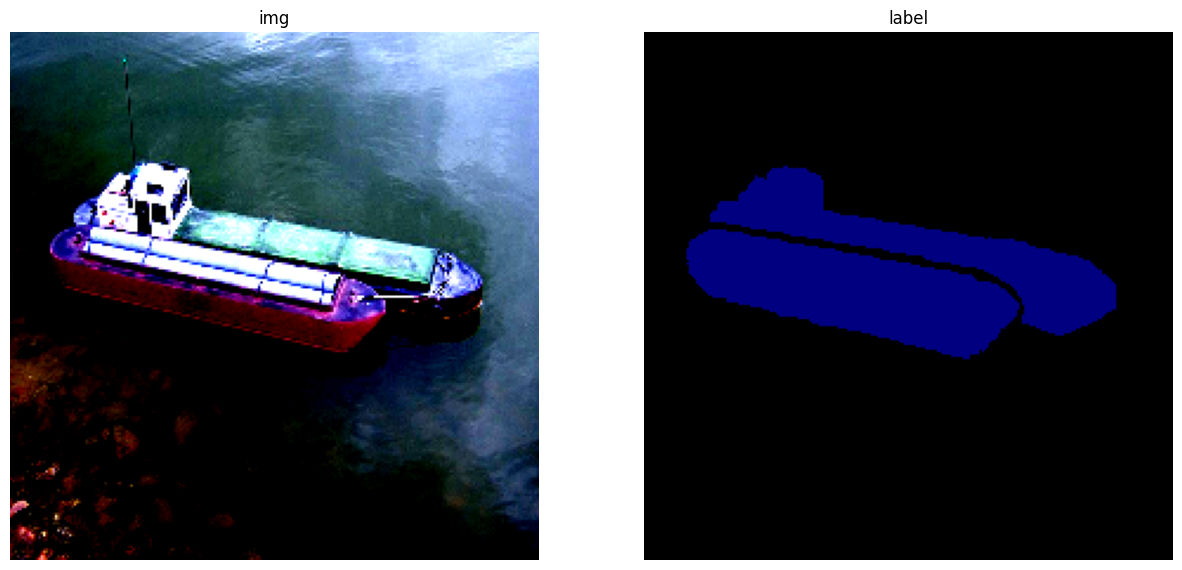

In [20]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [21]:
NUM_CLASS = 20

# model

In [22]:
model = DaNet(2048, NUM_CLASS + 1).to(DEVICE)

In [23]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DaNet                                         --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

In [24]:
model_path = artifacts_path.joinpath('danet.pth')

# train

In [25]:
EPOCHES = 30

In [26]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, 1)

In [27]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
training_loss = trainer.run(train_loader, model, optimizer, criterion)


100%|██████████| 91/91 [03:16<00:00,  2.16s/it]


epoch 1 : 0.03134805991590678


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 2 : 0.01634304450599702


100%|██████████| 91/91 [00:48<00:00,  1.87it/s]


epoch 3 : 0.01365397204286777


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


epoch 4 : 0.011973140060205709


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


epoch 5 : 0.010719726783233685


100%|██████████| 91/91 [00:48<00:00,  1.88it/s]


epoch 6 : 0.01193295960611367


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 7 : 0.011683492834301113


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 8 : 0.00917614762579183


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 9 : 0.007709035639661354


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 10 : 0.007425622656368292


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 11 : 0.00741049635050061


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 12 : 0.0068648989557974285


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 13 : 0.005530606402636884


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 14 : 0.0053238188592041585


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 15 : 0.0045266545884270265


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 16 : 0.0040329610033390615


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 17 : 0.00434355633742698


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 18 : 0.0078038660512602595


100%|██████████| 91/91 [00:47<00:00,  1.93it/s]


epoch 19 : 0.008972778921476104


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 20 : 0.007131314462890009


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 21 : 0.004415451464560497


100%|██████████| 91/91 [00:47<00:00,  1.93it/s]


epoch 22 : 0.0037559156720577687


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 23 : 0.003283742474965178


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 24 : 0.0029334651183459785


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 25 : 0.002740639538227857


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 26 : 0.002577960033194868


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 27 : 0.0024374953054075877


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 28 : 0.0023776388389396145


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 29 : 0.002369595039124181


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]

epoch 30 : 0.002248103424630404


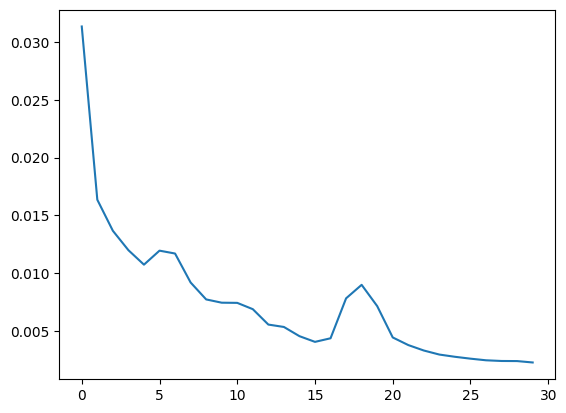

In [29]:
plt.plot(training_loss)

In [30]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
torch.save(model.state_dict(), model_path)

In [31]:
get_file_size(model_path)

'107.1MB'

# inference

In [32]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [34]:
test_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [35]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [36]:
model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(NUM_CLASS+1):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 92/92 [00:43<00:00,  2.13it/s]


In [37]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.7663277
bicycle 0.3966945
bird 0.80723876
boat 0.743376
bottle 0.69320214
bus 0.75974
car 0.8961035
cat 0.8906657
chair 0.75763106
cow 0.661682
diningtable 0.75698847
dog 0.8794615
horse 0.7391909
motorbike 0.7052224
person 0.9246983
pottedplant 0.62808424
sheep 0.64623696
sofa 0.8188426
train 0.8055768
tvmonitor 0.710069
mean dice: 0.7493516


### for image in dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


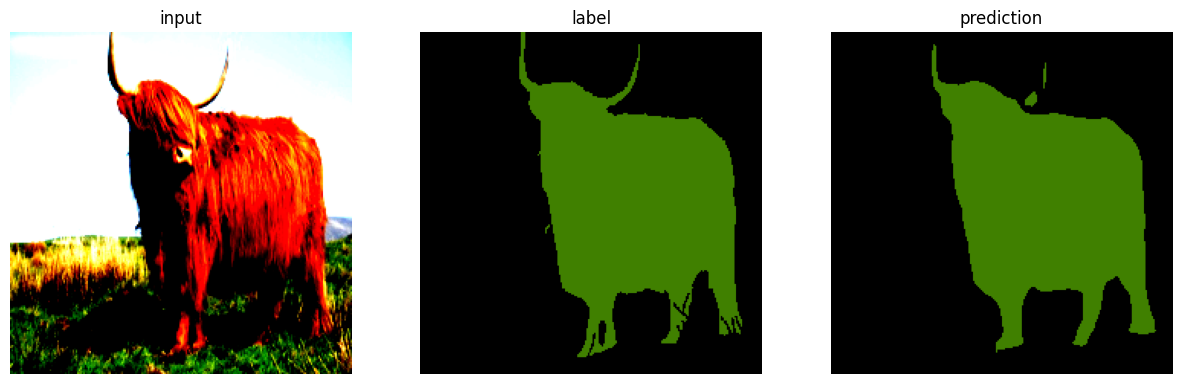

In [38]:
interest_pic = 1523

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

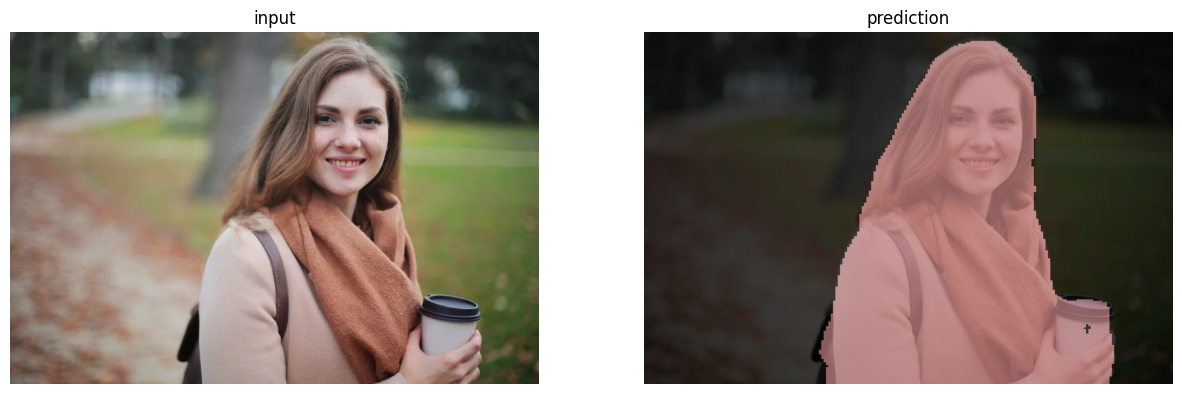

In [39]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )